**Importing the necessary libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#Ignoring warnings 
import warnings
warnings.filterwarnings('ignore')

**Loading the Data**

In [47]:
df = pd.read_csv('online_retail.csv')

**Understanding the data**

In [49]:
df.shape

(541909, 8)

In [ ]:
## There are more than 5 Lakh rows and 8 columns ##

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [25]:
## From the info we can infer that there are some missing values in Description column . Out of 541909 total records only 540455 are non null ##
## Similarly Customer Id also has many missing values . Only 406829 are non null out of 541909 records ##
## Invoice Date is a datetime column . It is currently object and hence conversion is needed there ##

In [11]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2022-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2022-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2022-12-01 08:34:00,1.69,13047.0,United Kingdom


In [31]:
## In a single transaction , multiple products can be purchased ##
## Same customer can make mupliple transactions in a single day ##
## Customer ID is currently in float . Conversion to INT might be required ##

In [13]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
## Negative values in Quantity and UnitPrice doesnt seem to be valid and it needs to be handled ##
## There is a huge gap between 75 th percentile and max value in Quantity and UnitPrice . This indicates presence of outliers ##

In [15]:
df.describe(include="object")

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2023-10-31 14:41:00,United Kingdom
freq,1114,2313,2369,1114,495478


In [49]:
## Most frequent Invoice no. is 573585 . There are 1114 items ordered in a single transaction ##
## Out of 541909 total records , 495478 transactions are made from UK . More than 90% orders are from UK ##

In [51]:
df.duplicated().sum()

5268

In [ ]:
## 5268 Duplicate records are present in the data . We need to handle it for proper results ##

**Data Cleaning**

In [ ]:
## From the initial analysis it was evident that there are missing values in CustomerId column and Description ##
## We are going to remove the missing values ##
## Since large number of Customer Ids are not present , impute process is not feasible since it will introduce bias ##
## Small percentage of Desctiption column is null . We will remove it as well ##

In [53]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [55]:
missing_description_rows = df[df['Description'].isnull()]
missing_description_rows.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2022-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2022-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2022-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2022-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2022-12-01 14:34:00,0.0,NaN,United Kingdom
1988,536550,85044,NaN,1,2022-12-01 14:34:00,0.0,NaN,United Kingdom
2024,536552,20950,NaN,1,2022-12-01 14:34:00,0.0,NaN,United Kingdom
2025,536553,37461,NaN,3,2022-12-01 14:35:00,0.0,NaN,United Kingdom
2026,536554,84670,NaN,23,2022-12-01 14:35:00,0.0,NaN,United Kingdom
2406,536589,21777,NaN,-10,2022-12-01 16:50:00,0.0,NaN,United Kingdom


In [57]:
missing_customerID_rows = df[df['Description'].isnull()]
missing_customerID_rows.tail(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
524473,580580,21804,NaN,10,2023-12-05 10:33:00,0.0,NaN,United Kingdom
524475,580588,21808,NaN,5,2023-12-05 10:35:00,0.0,NaN,United Kingdom
529667,580743,47591B,NaN,1,2023-12-06 09:30:00,0.0,NaN,United Kingdom
533711,581102,21803,NaN,20,2023-12-07 11:57:00,0.0,NaN,United Kingdom
533712,581103,22689,NaN,4,2023-12-07 11:58:00,0.0,NaN,United Kingdom
535322,581199,84581,NaN,-2,2023-12-07 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,2023-12-07 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,2023-12-07 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,2023-12-08 10:33:00,0.0,NaN,United Kingdom
538554,581408,85175,NaN,20,2023-12-08 14:06:00,0.0,NaN,United Kingdom


**Removing rows with missing customerId and description**

In [59]:
df_copy = df.copy()

In [61]:
df.dropna(subset=['CustomerID'], inplace=True)

In [63]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
## Missing description rows also got removed . This shows that wherever description is null , customerid is also null ##

In [65]:
df.shape

(406829, 8)

**Removing duplicates**

In [67]:
duplicate_rows = df[df.duplicated(keep=False)]

In [69]:
duplicate_rows
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode'])

In [71]:
duplicate_rows_sorted.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2022-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2022-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2022-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2022-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2022-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2022-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2022-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2022-12-01 11:45:00,2.95,17908.0,United Kingdom
565,536412,21448,12 DAISY PEGS IN WOOD BOX,2,2022-12-01 11:49:00,1.65,17920.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2022-12-01 11:49:00,1.65,17920.0,United Kingdom


In [73]:
## Removing the duplicate rows ##
df.drop_duplicates(inplace=True)

In [75]:
df.shape

(401604, 8)

In [168]:
## There are some cancelled transactions present in the dataset ##
## Invoice No. starts with C for those transactions ##

In [77]:
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
cancelled_transactions = df[df['InvoiceNo'].str.startswith('C')]
cancelled_transactions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2022-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2022-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2022-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2022-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2022-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2023-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2023-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2023-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2023-12-09 11:58:00,1.25,17315.0,United Kingdom


In [79]:
Cancel_Tran_Quantity = (cancelled_transactions['Quantity'] < 0).all()
print(Cancel_Tran_Quantity)

True


In [180]:
## We can see that there are 8872 cancelled transactions and the product quantities are negative for those transactions ##
## Removing these records ##

In [81]:
df = df[df['InvoiceNo'].astype(str).str.startswith('C') == False]

In [83]:
df.shape

(392732, 8)

In [230]:
## Checking for 0 value in UnitPrice and removing those records ##

In [85]:
zero_price_count = (df['UnitPrice'] == 0).sum()
zero_price_count

40

In [87]:
df = df[df['UnitPrice'] != 0]

In [89]:
df.shape

(392692, 8)

**Exploratory Data Analysis**

**1. Analysing transaction volume by country**

In [91]:
## Counting the unique transactions per country ##
country_tran_volume = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
print(country_tran_volume)

Country
United Kingdom          16646
Germany                   457
France                    389
EIRE                      260
Belgium                    98
Netherlands                94
Spain                      90
Australia                  57
Portugal                   57
Switzerland                51
Finland                    41
Italy                      38
Norway                     36
Sweden                     36
Channel Islands            26
Poland                     19
Japan                      19
Denmark                    18
Austria                    17
Cyprus                     16
Unspecified                 8
Iceland                     7
Singapore                   7
Canada                      6
Malta                       5
Israel                      5
Greece                      5
USA                         5
Lithuania                   4
European Community          4
United Arab Emirates        3
Czech Republic              2
Bahrain                     2
Le

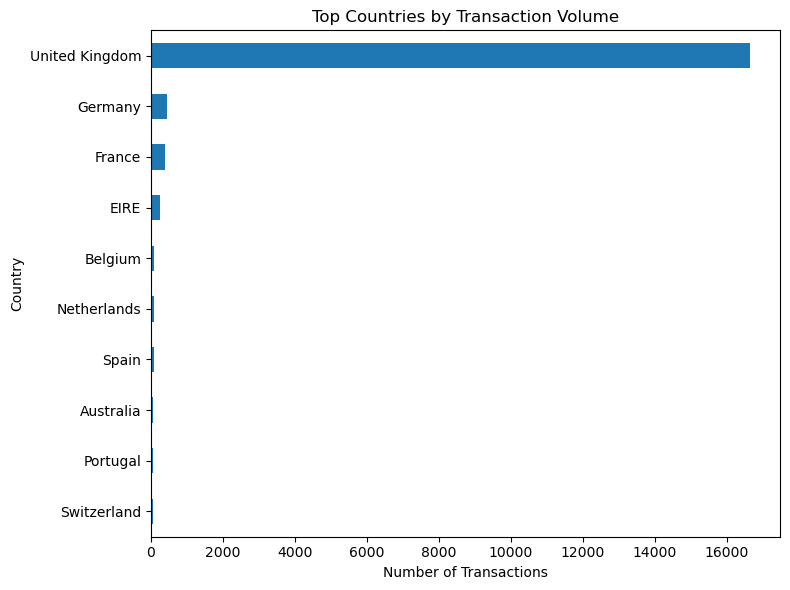

In [93]:
# Plot top 10 countries
top_countries = country_tran_volume.head(10)

plt.figure(figsize=(8,6))
top_countries.plot(kind='barh')
plt.title('Top Countries by Transaction Volume')
plt.xlabel('Number of Transactions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
## It can be seen that UK clearly dominates with more than 16000 unique transactions ##

**2. Identification of top-selling products**

In [95]:
top_products_by_quantity = (df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10))
print("Top 10 Products by Quantity Sold:")
print(" ")
print(top_products_by_quantity)

Top 10 Products by Quantity Sold:
 
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54319
JUMBO BAG RED RETROSPOT               46078
WHITE HANGING HEART T-LIGHT HOLDER    36706
ASSORTED COLOUR BIRD ORNAMENT         35263
PACK OF 72 RETROSPOT CAKE CASES       33670
POPCORN HOLDER                        30919
RABBIT NIGHT LIGHT                    27153
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64


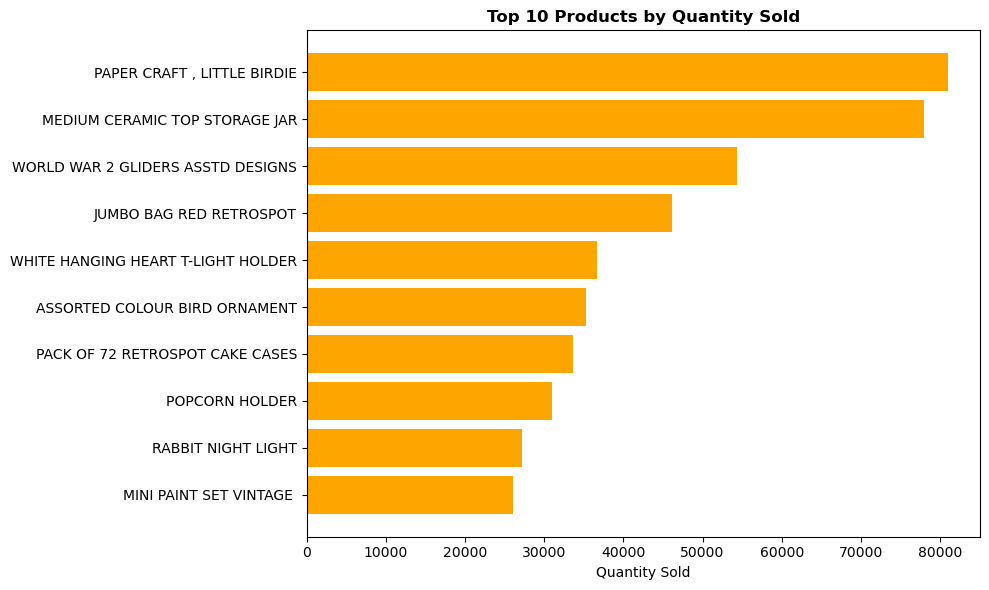

In [97]:
## Visualising the top selling products ##

plt.figure(figsize=(10,6))
axes = plt.barh(top_products_by_quantity.index, top_products_by_quantity.values, color='orange')

## Flipping y-axis to show highest at top ##
plt.gca().invert_yaxis()
plt.title('Top 10 Products by Quantity Sold', fontweight='bold')
plt.xlabel('Quantity Sold')
plt.tight_layout()


**Visualizing purchase trends over time**

In [99]:
df['InvoiceDate'].min()

'2022-12-01 08:26:00'

In [101]:
df['InvoiceDate'].max() ## Data is available for one year . Hence we can visualise product sales on monthly basis ##

'2023-12-09 12:50:00'

In [103]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [105]:
## Converting InvoiceDate to datetime format ##
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## Extracting month and calculating revenue per month ##
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

## Grouping by month and product and finding the sum ##
monthly_product_sales = df.groupby(['Month', 'Description'])['TotalPrice'].sum().reset_index()
top_products = (monthly_product_sales.sort_values(['Month', 'TotalPrice'], ascending=[True, False]).groupby('Month').head(1))
print(top_products)


         Month                          Description  TotalPrice
1770   2022-12             REGENCY CAKESTAND 3 TIER    17581.50
3526   2023-01       MEDIUM CERAMIC TOP STORAGE JAR    77183.60
6077   2023-02             REGENCY CAKESTAND 3 TIER     9559.65
8293   2023-03             REGENCY CAKESTAND 3 TIER    14784.65
10504  2023-04             REGENCY CAKESTAND 3 TIER    12721.50
12502  2023-05                        PARTY BUNTING    13408.25
14844  2023-06       PICNIC BASKET WICKER 60 PIECES    39619.50
17416  2023-07             REGENCY CAKESTAND 3 TIER    12174.00
19174  2023-08              JUMBO BAG RED RETROSPOT     9697.44
22587  2023-09  SET OF TEA COFFEE SUGAR TINS PANTRY     9842.92
24521  2023-10                               Manual    21183.63
27557  2023-11                   RABBIT NIGHT LIGHT    23190.41
29751  2023-12          PAPER CRAFT , LITTLE BIRDIE   168469.60


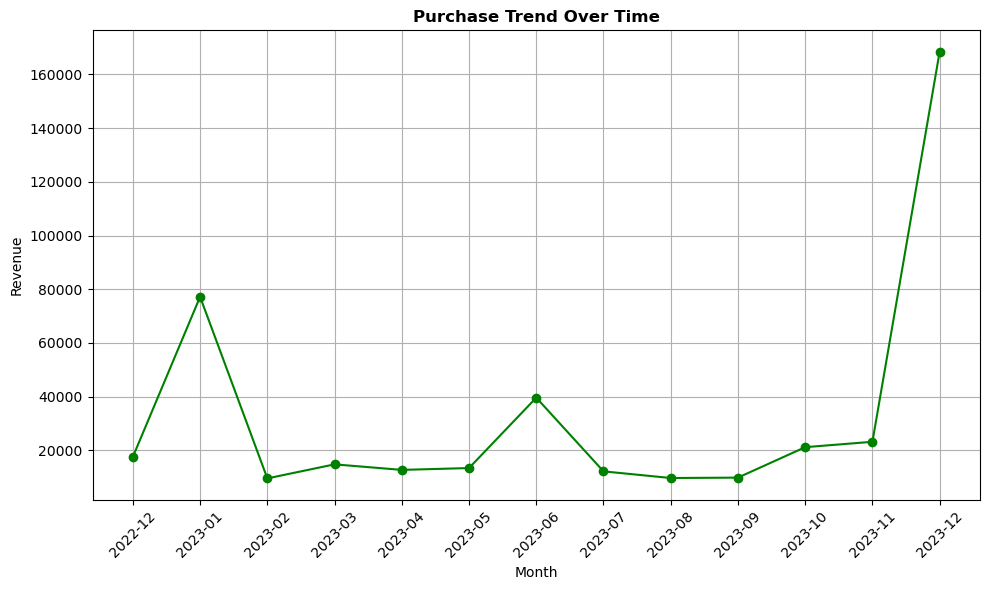

In [107]:
plt.figure(figsize=(10,6))
plt.plot(top_products['Month'].astype(str), top_products['TotalPrice'], marker='o',color='green')
plt.title('Purchase Trend Over Time', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [109]:
df['CustomerID'].nunique()

4338

In [ ]:
## There are 4338 unique customers . Now we will visulaise the monetary - spending distribution ##

**Monetary distribution per transaction and customer**

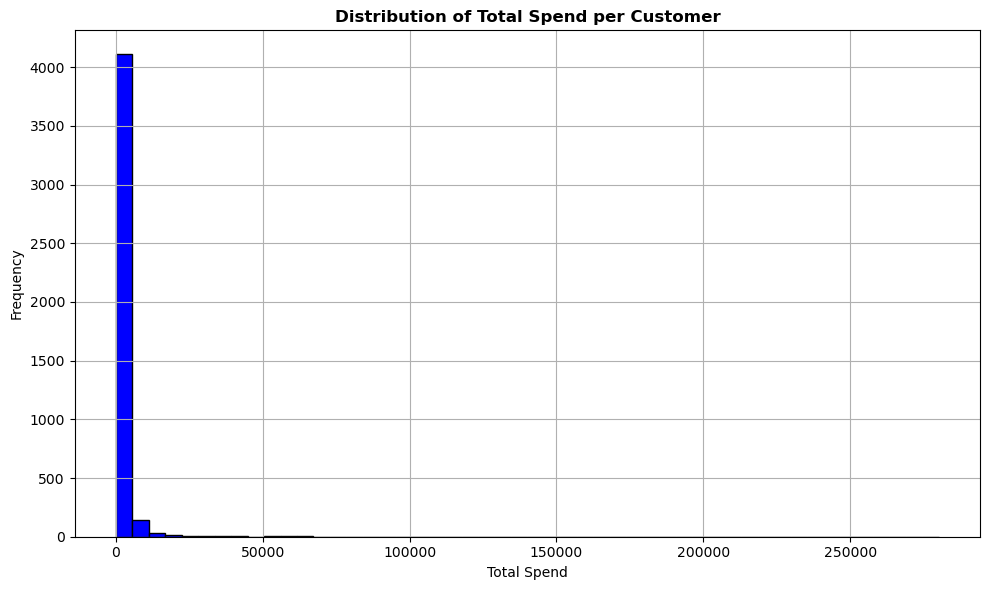

In [111]:
## Calculating total spend per customer ##
customer_spend = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(10,6))
customer_spend.plot(kind='hist', bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Total Spend per Customer', fontweight='bold')
plt.xlabel('Total Spend')
plt.grid(True)
plt.tight_layout()
plt.show()


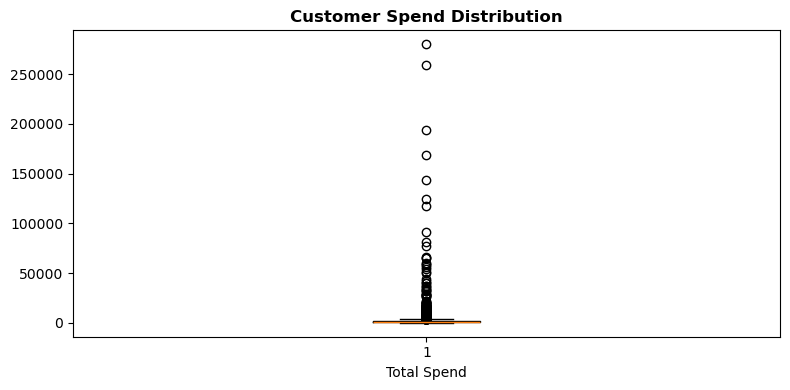

In [113]:
plt.figure(figsize=(8,4))
plt.boxplot(customer_spend)
plt.title('Customer Spend Distribution', fontweight='bold')
plt.xlabel('Total Spend')
plt.tight_layout()
plt.show()


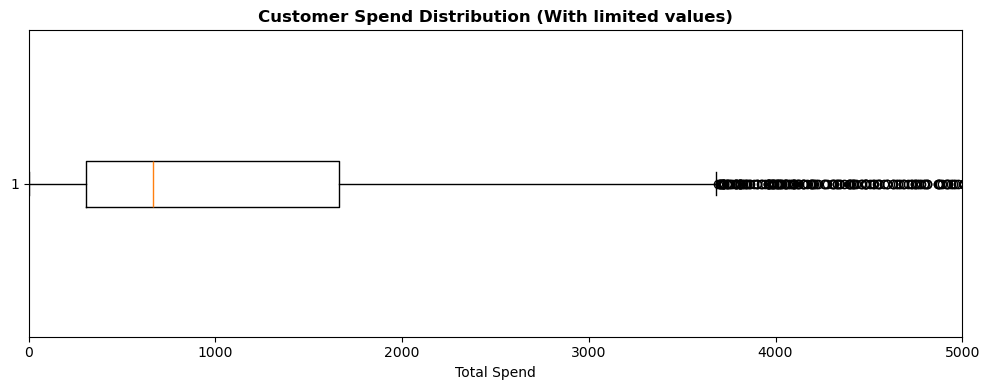

In [115]:
plt.figure(figsize=(10,4))
plt.boxplot(customer_spend, vert=False)
plt.xlim(0, 5000)  ## Limiting the value for better view ##
plt.title('Customer Spend Distribution (With limited values)', fontweight='bold')
plt.xlabel('Total Spend')
plt.tight_layout()
plt.show()


In [117]:
## Calculating the Quantiles ##
q1 = customer_spend.quantile(0.25)
median = customer_spend.median()
q3 = customer_spend.quantile(0.75)
print(f"Q1 = {q1}\nMEDIAN = {median}\nQ3 = {q3}")

Q1 = 306.48249999999996
MEDIAN = 668.57
Q3 = 1660.5974999999999


In [ ]:
## From the plots it is clear that most customers make low-cost purchases ## 
## Some customers spend more - which is shown as outliers ##

## Q1 (Lowe Quartile) ~ 307 . 25 % customers spend less that 307 ##
## Half of the customers spend less than 669 ##
## Q3 (Upper Quartile)  ~ 1661 . This means 75% of customers spend less than 1661 . Only the top 25% go beyond this amount. ##


In [119]:
df.shape

(392692, 10)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
 8   Month        392692 non-null  period[M]     
 9   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4), period[M](1)
memory usage: 33.0+ MB


In [123]:
## Finding the latest date for Recency calculation ##
Latest_date = df['InvoiceDate'].max()
print(Latest_date)

2023-12-09 12:50:00


**Forming a new RFM - Recency Frequency Monetary DataFrame**

In [125]:
rfm_df = df.groupby('CustomerID').agg({
'InvoiceDate': lambda x: (Latest_date - x.max()).days,  ## Recency
'InvoiceNo': 'nunique',                                 ## Frequency
'TotalPrice': 'sum'                                     ## Monetary
}).reset_index()

In [127]:
rfm_df.shape

(4338, 4)

In [129]:
rfm_df.head(10)

,CustomerID,InvoiceDate,InvoiceNo,TotalPrice
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
5,12352.0,35,8,2506.04
6,12353.0,203,1,89.00
7,12354.0,231,1,1079.40
8,12355.0,213,1,459.40
9,12356.0,22,3,2811.43


In [131]:
## Renaming the columns ##
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [133]:
rfm_df.head(10)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
5,12352.0,35,8,2506.04
6,12353.0,203,1,89.00
7,12354.0,231,1,1079.40
8,12355.0,213,1,459.40
9,12356.0,22,3,2811.43


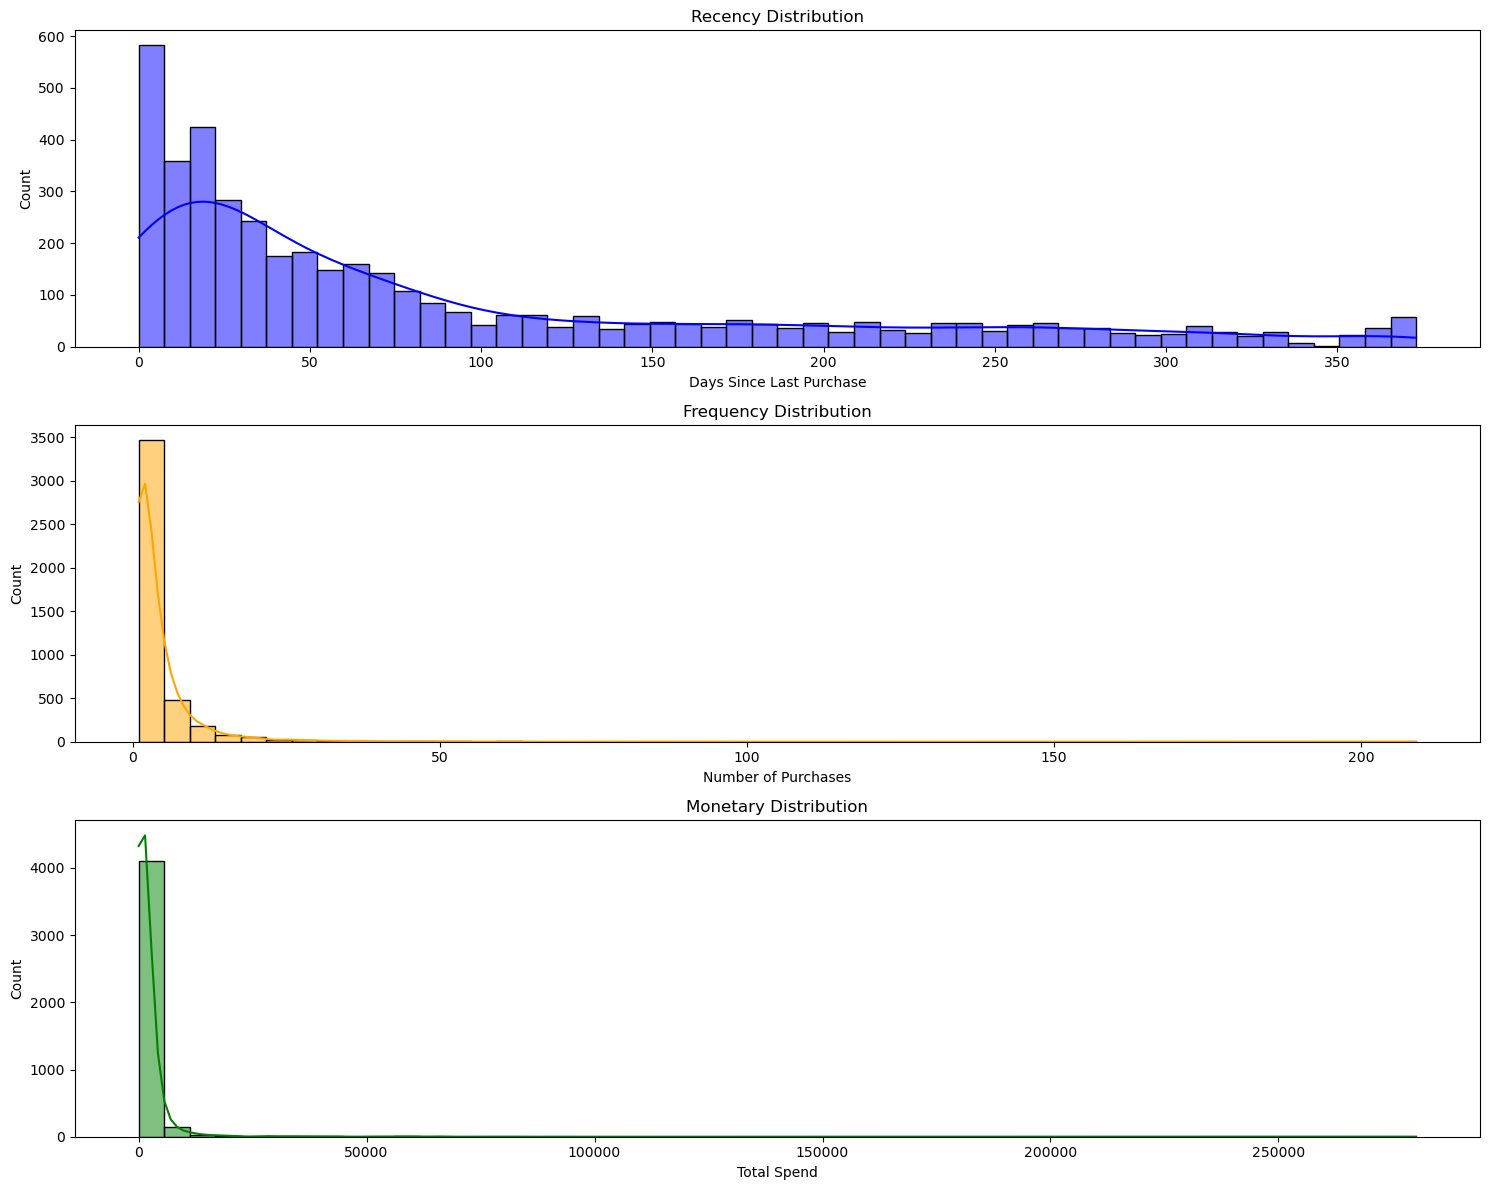

In [135]:
## Visualising RFM distribution ##

plt.figure(figsize=(15,12))

## Recency
plt.subplot(3, 1, 1)
sns.histplot(rfm_df['Recency'], bins=50, kde=True, color='blue')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')

## Frequency
plt.subplot(3, 1, 2)
sns.histplot(rfm_df['Frequency'], bins=50, kde=True, color='orange')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')

## Monetary
plt.subplot(3, 1, 3)
sns.histplot(rfm_df['Monetary'], bins=50, kde=True, color='green')
plt.title('Monetary Distribution')
plt.xlabel('Total Spend')

plt.tight_layout()
plt.show()


In [ ]:
## From the RFM distribution it is clear that Most customers are active . They have made recent purchases. ##
## Majority customers are one time buyers . Around 3000 customers are around the Frequency of 1 or 2##
## Most customers spend less . Below 5000 ##

In [137]:
rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,91.536422,4.272015,2048.688081
std,1721.808492,100.014169,7.697998,8985.230220
min,12346.000000,0.000000,1.000000,3.750000
25%,13813.250000,17.000000,1.000000,306.482500
50%,15299.500000,50.000000,2.000000,668.570000
75%,16778.750000,141.000000,5.000000,1660.597500
max,18287.000000,373.000000,209.000000,280206.020000


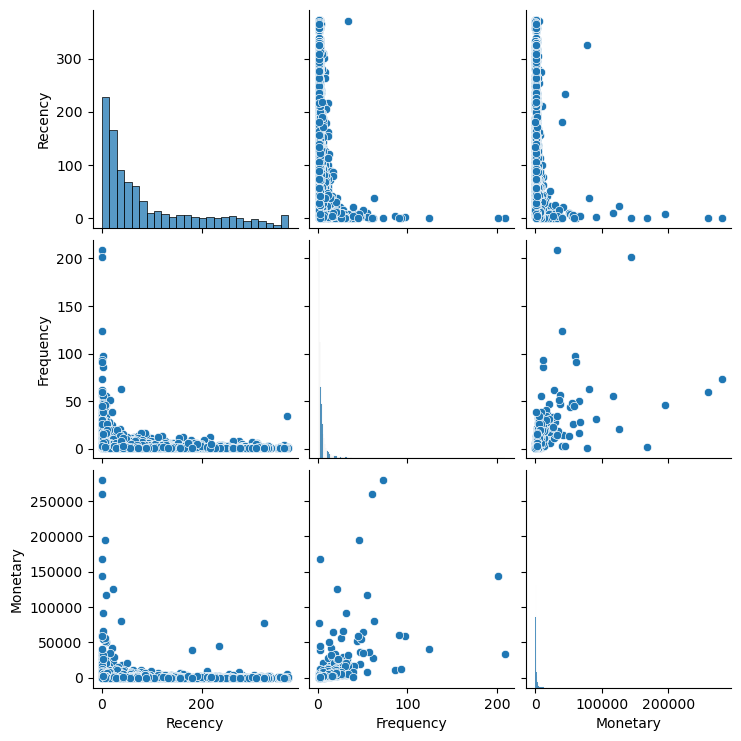

In [139]:
sns.pairplot(rfm_df[['Recency', 'Frequency', 'Monetary']])
plt.show()


**Observations:**

**Recency vs Frequency:**
    
    Negative relationship:As Recency decreases, Frequency tends to increase.
    Cluster of customers with low Recency and low Frequency (new or inactive customers).
    Outliers: Some customers have high Frequency, even if Recency is higher (they were active in the past but not recently).

**Recency vs Monetary:**
    
    Weak or no clear trend, but slight negative correlation: recent buyers tend to spend more.
    A few customers with high spend but high Recency – possibly lost big spenders.
    
**Frequency vs Monetary:**
    
    Positive correlation: As Frequency increases, Monetary tends to increase.
    Dense cluster at the bottom (low Frequency, low spend).
    A few extreme outliers with very high spend .

In [ ]:
## The range of values is huge . Monetary values ranges upto 250000 whereas Frequency and Recency are low values . Mostly below 300 ##
## Since clustering algorithms are distance based , scaling the features is important . Hence we are applying standard scaler ##

In [141]:
from sklearn.preprocessing import StandardScaler

X = rfm_df[['Recency', 'Frequency', 'Monetary']]

## Applying StandardScaler ##
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [143]:
rfm_scaled = pd.DataFrame(X_scaled,columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled.head(10)

,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.363010
1,-0.905340,0.354417,0.251699
2,-0.175360,-0.035340,-0.027988
3,-0.735345,-0.425097,-0.032406
4,2.174578,-0.425097,-0.190812
5,-0.565349,0.484336,0.050906
6,1.114606,-0.425097,-0.218126
7,1.394599,-0.425097,-0.107888
8,1.214604,-0.425097,-0.176898
9,-0.695346,-0.165259,0.084898


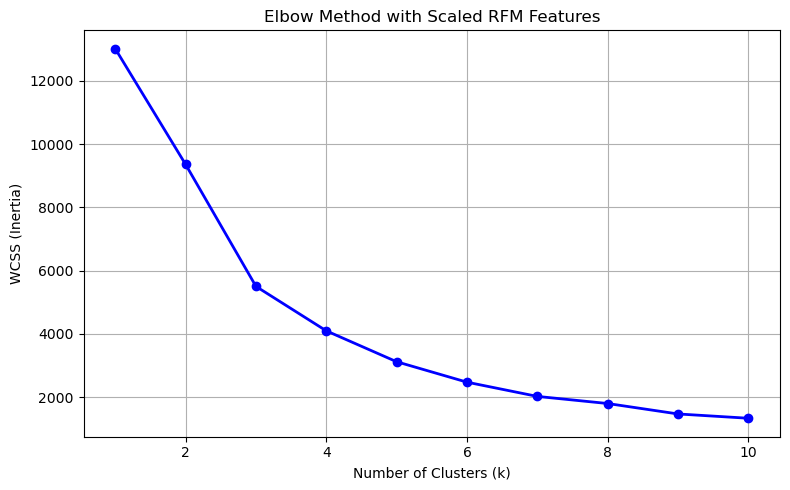

In [145]:
## Applying Elbow method on scaled data and visualise them ##
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

## Plotting the Elbow Curve ##
plt.figure(figsize=(8,5))
plt.plot(K, wcss, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method with Scaled RFM Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [564]:
## There is a big drop in curve from cluster 1 to 3 ##
## Curve bends around cluster 4 or 5 → This is the “elbow” — the best place to stop adding clusters. ##
## After this point, more clusters don’t help much ##

In [ ]:
## Now we are going to apply different clustering algorithms and evaluate them ##

**K Means Algorithm**

In [147]:
kmeans_model = KMeans(n_clusters=4,init='k-means++',n_init=20,max_iter=500,random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_scaled)

In [149]:
np.unique(kmeans_labels)

array([0, 1, 2, 3])

**DBSCAN Algorithm**

In [151]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

In [153]:
np.unique(dbscan_labels)

array([-1,  0], dtype=int64)

**Hierarchical (Agglomerative)**

In [155]:
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)
np.unique(hierarchical_labels)

array([0, 1, 2, 3], dtype=int64)

**Evaluating the algorithms using Silhouette score**

In [157]:
print("K-Means Silhouette Score:", round(silhouette_score(X_scaled, kmeans_labels),2))
print("DBSCAN Silhouette Score:", round(silhouette_score(X_scaled, dbscan_labels),2))
print("Hierarchical Silhouette Score:", round(silhouette_score(X_scaled, hierarchical_labels),2))

K-Means Silhouette Score: 0.62
DBSCAN Silhouette Score: 0.84
Hierarchical Silhouette Score: 0.61


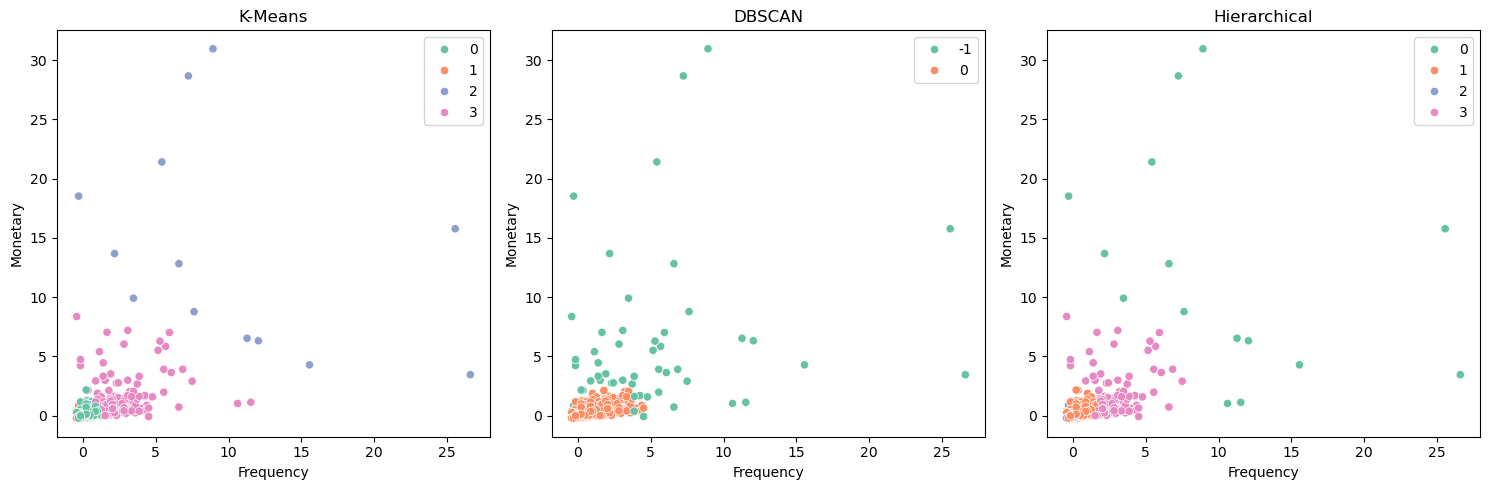

In [159]:
## Visualising the clusters ##

plt.figure(figsize=(15,5))

for i, labels in enumerate([kmeans_labels, dbscan_labels, hierarchical_labels]):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=labels, palette='Set2')
    plt.title(['K-Means', 'DBSCAN', 'Hierarchical'][i])
    plt.xlabel('Frequency')
    plt.ylabel('Monetary')

plt.tight_layout()
plt.show()


In [ ]:
## We are going to consider KMeans for further computations . Silhoutte score > 0.5 is considered good ##
## Now we need to reduce dimensionality for better visualization using PCA ##

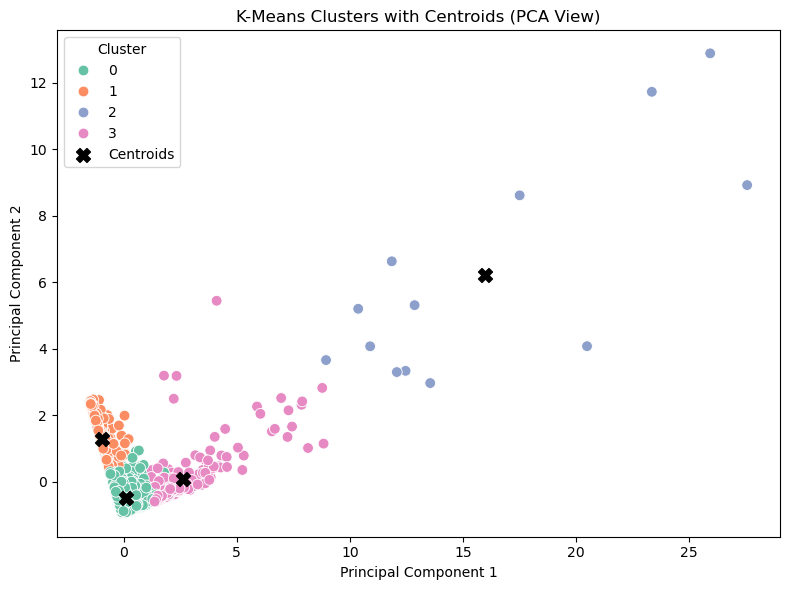

In [161]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
## Going to view along with centroids ##
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)

## Plotting clusters and centroids ##
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set2', s=60)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=100, c='black', label='Centroids')
plt.title("K-Means Clusters with Centroids (PCA View)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
## The 4 clusters are visually clear and distinct in PCA space. ##
## This means K-Means segmentation is effective and customers have differing behavioral patterns. ##
## The centroids are also in the middle of the cluster which shows thats data points in the same group are very similar to each other. ##

In [163]:
## Assigining the cluster labels to the rfm data frame ##
rfm_df['Cluster'] = kmeans_labels 

In [197]:
## Finding the average values of RFM for each cluster ##
cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2).reset_index()
cluster_summary

,Cluster,Recency,Frequency,Monetary
0,0,42.70,3.68,1353.63
1,1,247.08,1.55,478.85
2,2,6.38,82.54,127187.96
3,3,14.50,22.33,12690.50


**Observations:**

Cluster 0 - High Recency(old purchases),Low Frequency,Low Monetary  --> Occasional Customers

Cluster 1 - Very old Recency,Very Low Frequency,Very Low Monetary --> At-Risk Customers

Cluster 2 - Low Recency(Recent purchases),High Frequency,High Monetary --> High-Value Customers

Cluster 3 - Medium Recency,Medium Frequency,Medium Monetary --> Regular Customers 

In [199]:
## Creating Labels to the Clusters based on their patterns ##

segment_map = {
    2: "High-Value",
    3: "Regular",
    0: "Occasional",
    1: "At-Risk"
}

rfm_df['Segment'] = rfm_df['Cluster'].map(segment_map)

In [201]:
rfm_df.shape

(4338, 6)

In [203]:
rfm_df.head(10)

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,325,1,77183.60,3,Regular
1,12347.0,1,7,4310.00,0,Occasional
2,12348.0,74,4,1797.24,0,Occasional
3,12349.0,18,1,1757.55,0,Occasional
4,12350.0,309,1,334.40,1,At-Risk
5,12352.0,35,8,2506.04,0,Occasional
6,12353.0,203,1,89.00,1,At-Risk
7,12354.0,231,1,1079.40,1,At-Risk
8,12355.0,213,1,459.40,1,At-Risk
9,12356.0,22,3,2811.43,0,Occasional


In [193]:
#print(cluster_summary.columns)
#cluster_summary.reset_index(inplace=True)
#cluster_summary.set_index('Cluster', inplace=True)

In [205]:
print(cluster_summary.columns)

Index(['Cluster', 'Recency', 'Frequency', 'Monetary'], dtype='object')


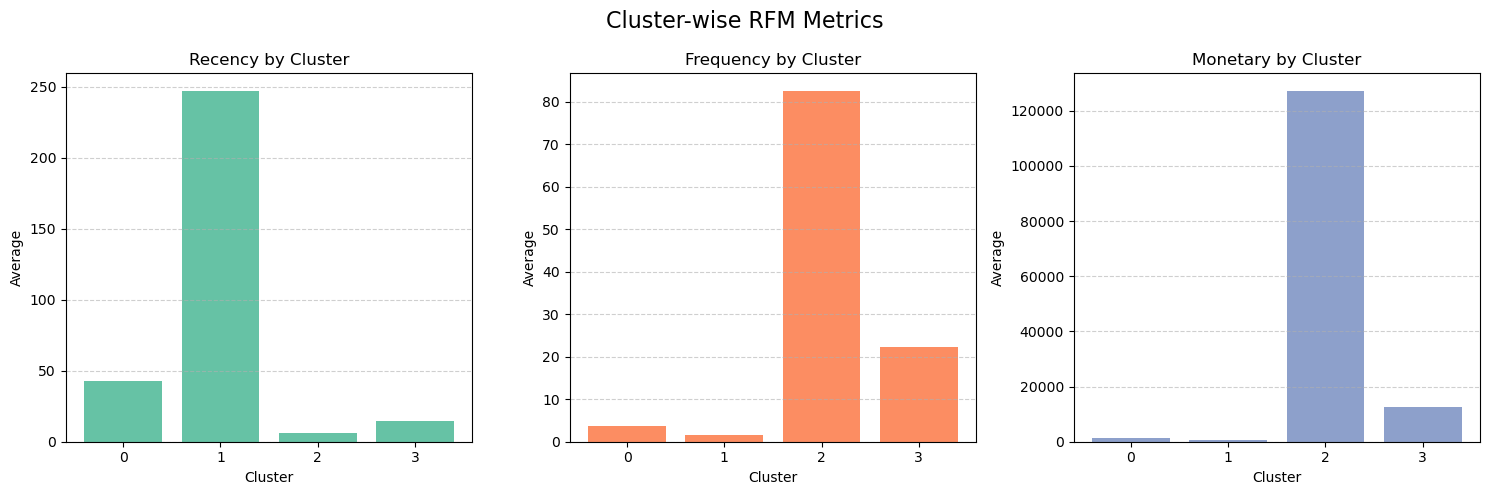

In [207]:
## Visualising Cluster-Wise summary of RFM ##

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
metrics = ['Recency', 'Frequency', 'Monetary']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

for i, metric in enumerate(metrics):
    axs[i].bar(cluster_summary['Cluster'], cluster_summary[metric], color=colors[i])
    axs[i].set_title(f'{metric} by Cluster')
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel('Average')
    axs[i].set_xticks(cluster_summary['Cluster'])
    axs[i].grid(axis='y', linestyle='--', alpha=0.6)
plt.suptitle('Cluster-wise RFM Metrics', fontsize=16)
plt.tight_layout()
plt.show()

**Recommendation system - Item based collaborative filtering**

In [209]:
## Forming the User-Item Matrix ##
user_item_matrix = df.pivot_table(index='CustomerID',columns='Description',  values='Quantity',aggfunc='sum').fillna(0)

## This matrix defines how many units of each item a customer bought ##
## Calculating Item similariry ##
from sklearn.metrics.pairwise import cosine_similarity

## Transpose so items are rows ##
item_user_matrix = user_item_matrix.T

## Calculationg cosine similarity between items ##
item_similarity = cosine_similarity(item_user_matrix)
similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)


In [211]:
similarity_df.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Description,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,1.000000,0.000000,0.000021,0.000228,0.000000,0.000000,0.020228,0.000000,0.000263,0.063543,...,0.0,0.001376,0.015917,0.001771,0.0,0.002852,0.0,0.013155,0.000000,0.002599
50'S CHRISTMAS GIFT BAG LARGE,0.000000,1.000000,0.003534,0.004001,0.000000,0.020230,0.027477,0.902593,0.119038,0.013384,...,0.0,0.001726,0.015572,0.018032,0.0,0.015710,0.0,0.011238,0.000000,0.029793
DOLLY GIRL BEAKER,0.000021,0.003534,1.000000,0.870965,0.980574,0.006358,0.005311,0.003040,0.001764,0.411471,...,0.0,0.000044,0.002869,0.344928,0.0,0.525868,0.0,0.822964,0.000097,0.006665
I LOVE LONDON MINI BACKPACK,0.000228,0.004001,0.870965,1.000000,0.883987,0.020076,0.004912,0.004051,0.008249,0.382226,...,0.0,0.001416,0.004198,0.310053,0.0,0.471772,0.0,0.749303,0.000000,0.010394
I LOVE LONDON MINI RUCKSACK,0.000000,0.000000,0.980574,0.883987,1.000000,0.000000,0.000000,0.000000,0.000000,0.410712,...,0.0,0.000000,0.000000,0.347021,0.0,0.530836,0.0,0.837176,0.000000,0.000000


In [229]:
## Using similarity df , recommendation function is defined ##
def recommend_items(input_item, similarity_df, top_n=5):
    input_item = input_item.strip().upper()
    if input_item not in similarity_df:
        return f"Product '{input_item}' not found in similarity data. Please check the spelling or try another item."
    # Exclude the item itself
    similar_items = similarity_df[input_item].drop(input_item)
    recommended = similar_items.sort_values(ascending=False).head(top_n)
    return recommended.index.tolist()


In [231]:
recommend_items('GREEN VINTAGE SPOT BEAKER', similarity_df)

['BLUE VINTAGE SPOT BEAKER',
 'PINK VINTAGE SPOT BEAKER',
 'POTTING SHED CANDLE CITRONELLA',
 'POTTING SHED ROSE CANDLE',
 'PANTRY CHOPPING BOARD']

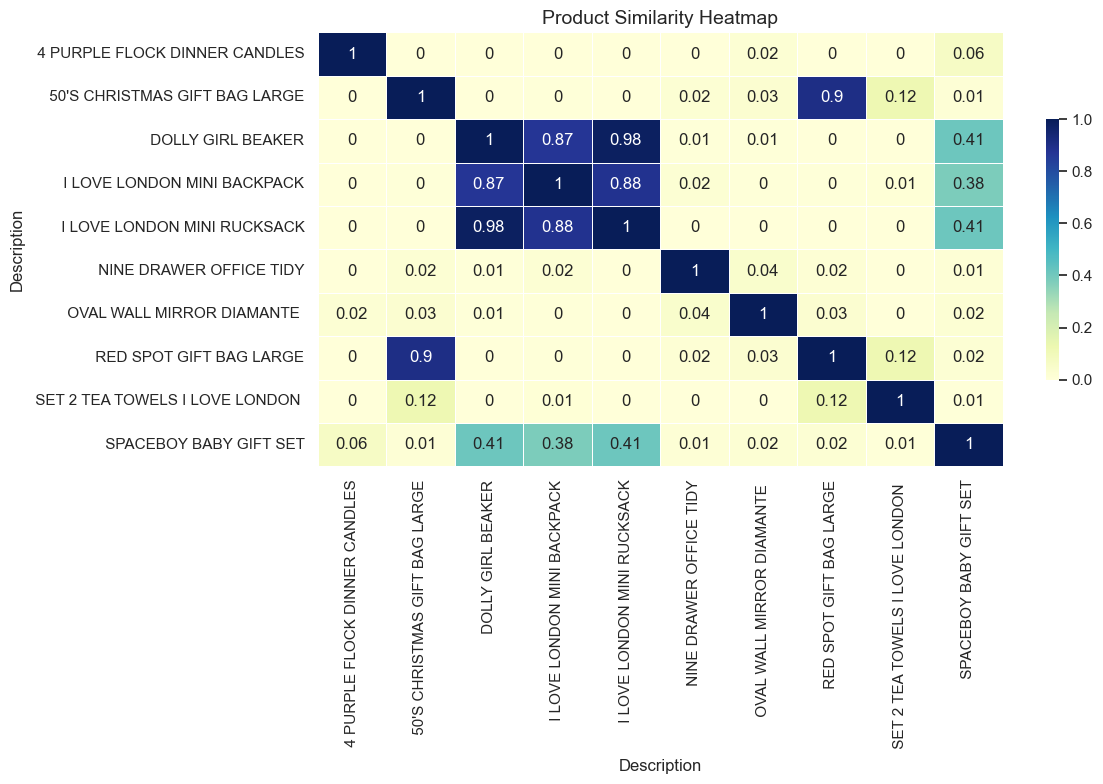

In [227]:
## Product recommendation heat map ##

## Reducing the matrix size for smoother rendering ##
reduced_df = similarity_df.iloc[:10, :10] 
plt.figure(figsize=(12, 8))
sns.set(style="white")
sns.heatmap(reduced_df,annot=np.round(reduced_df.values, 2),cmap="YlGnBu",linewidths=0.5,cbar_kws={"shrink": 0.6},xticklabels=True,yticklabels=True)
plt.title("Product Similarity Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

In [233]:
## Saving the KMeans Model ##
import joblib
joblib.dump(kmeans_model, 'kmeans.model')

['kmeans.model']

In [235]:
similarity_df.to_csv("product_similarity_matrix.csv")

In [237]:
joblib.dump(scaler, "standard_scaler.pkl")

['standard_scaler.pkl']